「[データ解析のための統計モデリング入門](https://www.amazon.co.jp/dp/400006973X?tag=kmgu-22)」の第3章です。前回の[確率分布と統計モデルの最尤推定](https://yuku.takahashi.coffee/blog/2020/01/maximum-likelihood-estimation-of-probability-distribution-and-statistical-model)の続きです。

まずは準備として、再現性のために乱数の種を設定します：

In [1]:
import Random
Random.seed!(0)
nothing

第3章では、架空植物 100 個体を調査して得られた、個体ごとの種子数のデータの分析をします。植物個体 $i$ の種子数は $y_i$ 個であり、また個体の属性の一つである体サイズ $x_i$ が観測されています。さらに、全体のうち 50 個体（$i \in \{1, 2, \dots, 50\}$）は何も処理をしていないけれど、残り 50 個体（$i \in \{51, 52, \dots, 100 \}$）には肥料を加える処理をほどこしています。

今回もダミーのデータを作ります。第3章のデータを作り方の説明が本文中にないのですが、ポアソン回帰を題材としているので、応答変数 $y_i$ はポアソン分布を使っていると想定し、説明変数 $x_i$ は p.44 のデータの概要からそれっぽい正規分布を使って作ってみました：

In [2]:
using DataFrames, Distributions
sizes = rand(Normal(10.0, 0.7), 100)
data = DataFrame()
data.y = [rand(Poisson(3.5 + 0.5size)) for size in sizes]
data.x = sizes
data.f = vcat(["C" for _ in 1:50], ["T" for _ in 1:50])

describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,y,8.51,1,8.5,18,,,Int64
2,x,9.98263,7.57284,9.95656,11.6197,,,Float64
3,f,,C,,T,2,,String


得られたデータを可視化してみます：

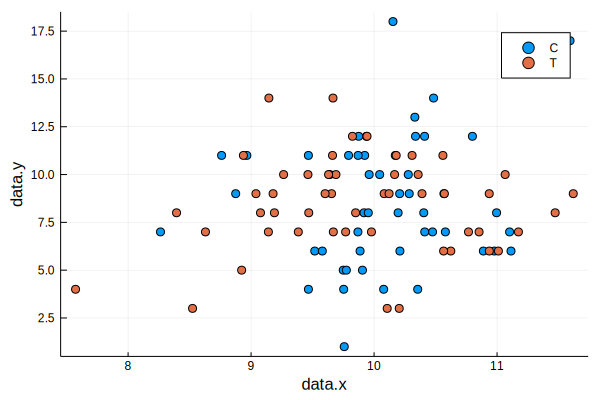

In [3]:
using Plots
scatter(data.x[data.f .== "C"], data.y[data.f .== "C"], label="C")
scatter!(data.x[data.f .== "T"], data.y[data.f .== "T"], label="T")
xlabel!("data.x")
ylabel!("data.y")

（データの作り方から当然ではありますが） $x_i$ が大きくなるに連れて $y_i$ が大きくなる傾向が見て取れます。それと比較すると $f_i$ は影響があるのか無いのか微妙な感じがします。

箱ひげ図も描画します：

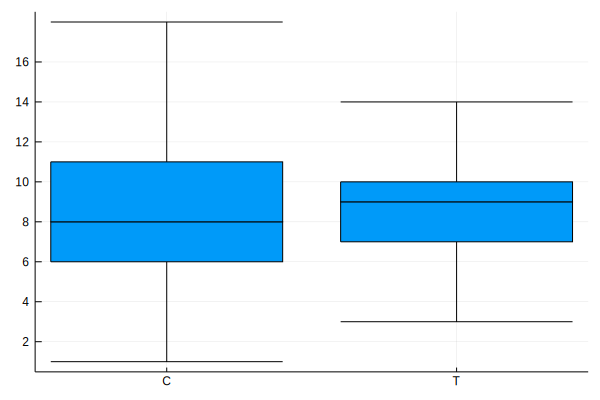

In [4]:
using StatsPlots
boxplot(data.f, data.y, legend=false, yticks=0:2:16)

### ポアソン回帰の統計モデル
[前回の記事](/blog/2020/01/maximum-likelihood-estimation-of-probability-distribution-and-statistical-model)でカウントデータはポアソン分布を使って表現できることを確認しました。今回のデータも種子数を数えたカウントデータ、ということになっているので、ポアソン分布で表現できそうです。ある個体 $i$ において種子数が $y_i$ である確率 $p(y_i|\lambda_i)$ はポアソン分布に従っていると仮定すると：

$$
p(y_i|\lambda_i) = \frac{\lambda_i^{y_i}\exp(-\lambda_i)}{y_i!}
$$

散布図を眺めた感じから施肥効果 $f_i$ はあまり種子数に効果がなさそうなので、体サイズ $x_i$ だけに依存する統計モデルについて考えてみます。この場合平均種子数 $\lambda_i$ を説明変数 $x_i$ の関数として定義すればいいので、詳しい種明かしはあとでするとしてひとまず以下のようにおいてみます：

$$
\lambda_i = \exp(\beta_1 + \beta_2 x_i)
$$

いくつか $\beta_1$ と $\beta_2$ を変えて、この関係を図示すると:

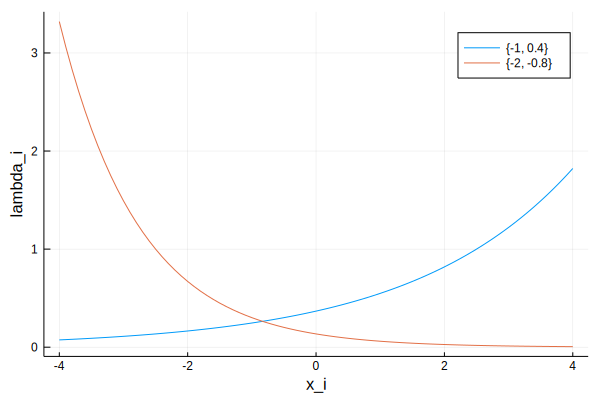

In [5]:
genlink = (β₁, β₂) -> (x) -> exp(β₁ + β₂ * x)
xs = -4:0.1:4
plot(xs, genlink(-1, 0.4), label="{-1, 0.4}")
xlabel!("x_i")
ylabel!("lambda_i")
plot!(xs, genlink(-2, -0.8), label="{-2, -0.8}")

$\lambda_i$ が非負の値になっていることが分かります。 ポアソン分布の平均 $\lambda_i$ は必ず非負でならなければなりませんが、これであれば説明変数 $x_i$ がどのような値でも自動的にこの条件が守られて都合がよさそうです。

ところで、この式は以下のように変形できます：

$$
\log \lambda_i = \beta_1 + \beta_2 x_i
$$

このときの右辺 $\beta_1 + \beta_2 x_i$ は ${\beta_1, \beta_2}$ の線形結合になっていることから、 **線形予測子**（linear predictor）と呼ばれます。またこの式のように（応答変数の期待値）=（線形予測子）となっているものを **リンク関数**（link function）と呼びます。今回の場合は対数関数なので **対数リンク関数**（log link function）です。リンク関数はモデルごとによく使われるものがある程度決まっていて、前述の理由からポアソン回帰ではたいていは対数リンク関数が使われます。

ポアソン回帰はポアソン分布を使った統計モデルの対数尤度 $\log L$ が最大になるパラメータ $\hat{\beta}_1$ と $\hat{\beta}_2$ の推定値を求めます。この対数尤度は：

$$
\log L(\beta_1, \beta_2) = \sum_i \log \frac{\lambda_i^{y_i} \exp(-\lambda_i)}{y_i!}
$$

パラメータが 2 つあるので解析的に答えを求めるのは簡単ではありませんが、 Julia の [GLM](https://juliastats.org/GLM.jl/stable/) パッケージを使うと切片 $\beta_1$ と傾き $\beta_2$ の最尤推定値を簡単に求めることができます。

In [7]:
using GLM
fit = glm(@formula(y ~ x), data, Poisson(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────
              Estimate  Std.Error  z value  Pr(>|z|)
────────────────────────────────────────────────────
(Intercept)  1.6692     0.470286   3.54932    0.0004
x            0.0472266  0.0468658  1.0077     0.3136
────────────────────────────────────────────────────

この出力内容は p.50 の `summary(fit)` を実行したときと対応しています。 $\hat{\beta}_1$ と $\hat{\beta}_2$ はそれぞれ 1.67 と 0.05 と推定されています。 `Std.Error` は **標準誤差**（standard error, SE）、 `z value` は最尤推定値を SE で除した z 値、あるいは **Wald 統計量**（Wald statistics）です。詳しくは書籍を参照してください。

[`@formula`](https://juliastats.org/StatsModels.jl/v0.6.7/formula/) は Julia の StatsModels package にあるマクロです。本に書かれた R コードと記述の方法が同じなので、おそらく R から移植されたものなのだと思いますが、`y` とか `x` という変数は存在しないのに、いきなり第一引数で使うのがなかなか違和感があります：

```r
fit <- glm(y ~ x, data = d, familly = poisson)
```

話を戻して、得られたモデルの最大対数尤度を評価するには [StatsBase](https://juliastats.org/StatsBase.jl/latest) パッケージの [`loglikelihood()` 関数](https://juliastats.org/StatsBase.jl/latest/statmodels/#StatsBase.loglikelihood)を使います：

In [8]:
loglikelihood(fit)

-248.9474224949767

最尤推定値とその周辺の様子とプロットしてみると、たしかにこの点で最大値をとっていることが分かります：

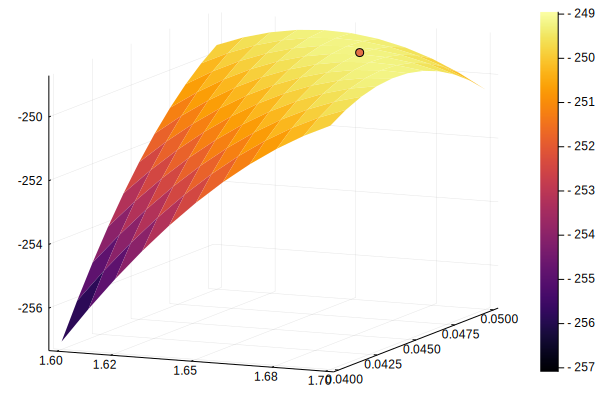

In [9]:
seq₁ = 1.6:0.01:1.7
seq₂ = 0.04:0.001:0.05
logL = (β₁, β₂) -> sum([logpdf(Poisson(exp(β₁ + β₂ * data.x[index])), y) for (index, y) in enumerate(data.y)])
plot(seq₁, seq₂, logL, st=:surface)

β̂₁ = 1.6692
β̂₂ = 0.0472266
maxL = -248.9474224949767
plot!([β̂₁], [β̂₂], [maxL], seriestype=:scatter, legend=false)

得られたポアソン回帰の推定結果を使って、さまざまな $x_i$ における平均種子数 $\lambda$ の予測をしてみると、若干の右肩上がりのグラフが得られました。

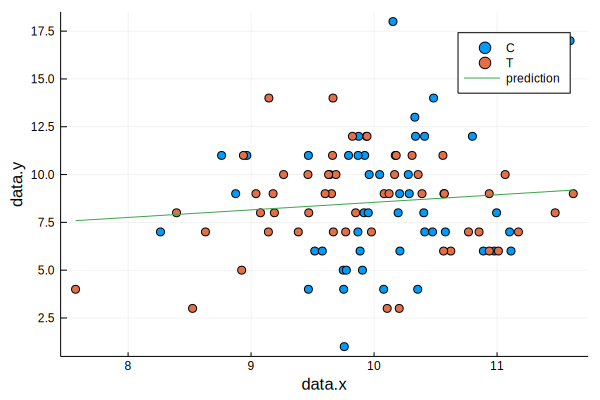

In [10]:
scatter(data.x[data.f .== "C"], data.y[data.f .== "C"], label="C")
scatter!(data.x[data.f .== "T"], data.y[data.f .== "T"], label="T")
xlabel!("data.x")
ylabel!("data.y")
xx = [minimum(data.x), maximum(data.x)]
plot!(xx, ((x) -> exp(1.6692 + 0.0472266x)).(xx), label="prediction")

### 説明変数が因子型の統計モデル

ここまで使ってきた説明変数 $x_i$ は数値でした。次は因子型データである $f_i$ です。この場合も使い方は同じで、そのまま `@formula` 関数で指定します。

今回の $f_i$ は 2 水準ですが、仮に $n$ 水準あったとすると：

$$
\lambda_i = \exp\Biggl(\beta_1 + \sum_j \beta_j d_{ij}\Biggr)
$$

このとき $d_{ij}$ は本の表現を借りるならダミー変数で $f_i$ が j 番目の因子だったときだけ 1 になります。たとえば今回は C と T の 2 水準なので：

$$
d_{ij} = \begin{cases}
0 & (f_i = \text{C}) \\
1 & (f_i = \text{T})
\end{cases}
$$

つまり $f_i$ = C の場合は:

$$
\lambda_i = \exp(\beta_1)
$$

$f_i$ = T の場合は：

$$
\lambda_i = \exp(\beta_1 + \beta_3)
$$

のようになります。（$\beta_2$ は $x_i$ に使っているので、あとの説明との整合性のために 3 にしています）

In [12]:
fit2 = glm(@formula(y ~ f), data, Poisson(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + f

Coefficients:
───────────────────────────────────────────────────────
               Estimate  Std.Error    z value  Pr(>|z|)
───────────────────────────────────────────────────────
(Intercept)   2.15409    0.0481682  44.7201      <1e-99
f: T         -0.0258534  0.0685648  -0.377065    0.7061
───────────────────────────────────────────────────────

$\hat{\beta}_1$ と $\hat{\beta}_3$ はそれぞれ $2.15$、 $-0.026$ と推定されています。`f: T` と書かれていることからここでいう $\beta_3$ は $f_i$ が T のときの傾きであると分かります。

In [13]:
loglikelihood(fit2)

-249.38600696156576

このモデルでの最大対数尤度は先程のモデルより小さくなりました。

### 説明変数が数量型＋因子型の統計モデル

$x_i$ と $f_i$ 両方を組み合わせた統計モデルも同様に求めることができます。

In [14]:
fit3 = glm(@formula(y ~ x + f), data, Poisson(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x + f

Coefficients:
───────────────────────────────────────────────────────
               Estimate  Std.Error    z value  Pr(>|z|)
───────────────────────────────────────────────────────
(Intercept)   1.69225    0.479588    3.52854     0.0004
x             0.0457861  0.0472654   0.968701    0.3327
f: T         -0.0174208  0.0690733  -0.252207    0.8009
───────────────────────────────────────────────────────

In [15]:
loglikelihood(fit3)

-248.9156152929941

まとめると

$$
\lambda_i = \begin{cases}
\exp(1.69 + 0.05 x_i) & (f_i = \text{C}) \\
\exp(1.69 + 0.05 x_i - 0.02) & (f_i = \text{T})
\end{cases}
$$

この式は （平均）=（定数）×（サイズの効果）×（施肥処理の効果）と分解できます。 $\exp(-0.02) = 0.98$ なので肥料をやると平均が 0.98 倍になると予測されています。